In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
from fastai import *
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
pd.set_option('display.float_format', lambda x: '%.4f' % x)

from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/Colab Notebooks/Python"
%ls
from error_metrics_2020 import *
from imv_networks import IMVFullLSTM

%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
warnings.filterwarnings(action='ignore')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Python
darnn_network_modified.py  imv_networks.py                   __pycache__/
darnn_network_russia.py    moving_window_tests_mod_dec17.py  title.jpg
error_metrics_2020.py      moving_window_tests_mod_dec28.py  utils.py
error_metrics.py           moving_window_tests.py


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Data"
#%ls
data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
# Save files here
%cd "/content/drive/My Drive/Colab Notebooks/Result/IMV"

/content/drive/My Drive/Colab Notebooks/Data
/content/drive/My Drive/Colab Notebooks/Result/IMV


In [ ]:
cbwd = pd.get_dummies(data['cbwd'])
cbwd.columns = ["cbwd_{}".format(i) for i in range(cbwd.shape[1])]
data = pd.concat([data, cbwd], axis=1)

In [ ]:
data.drop(['cbwd'], axis=1, inplace=True)
data = data.iloc[:,1:]
data.dropna(how='any',inplace=True)

In [ ]:
cols = list(data.columns[4:])
cols

['pm2.5',
 'DEWP',
 'TEMP',
 'PRES',
 'Iws',
 'Is',
 'Ir',
 'cbwd_0',
 'cbwd_1',
 'cbwd_2',
 'cbwd_3']

In [ ]:
depth = 10
X = np.zeros((len(data), depth, len(cols)))
for i, name in enumerate(cols):
    for j in range(depth):
        X[:, j, i] = data[name].shift(depth - j - 1).fillna(method='bfill')

y = data['pm2.5'].shift(-1).fillna(method='ffill').values

In [ ]:
train_bound = int(0.6*(len(data)))
val_bound = int(0.8*(len(data)))

train_bound, val_bound, data.shape, data.shape[0]-val_bound

(25054, 33405, (41757, 15), 8352)

In [ ]:
X_train = X[:train_bound]
X_val = X[train_bound:val_bound]
X_test = X[val_bound:]
y_train = y[:train_bound]
y_val = y[train_bound:val_bound]
y_test = y[val_bound:]

X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)
y_train = (y_train - y_train_min)/(y_train_max - y_train_min +1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

In [ ]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

# Model

In [ ]:
model = IMVFullLSTM(X_train_t.shape[2], 1, 512).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.8)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

Saving...
Iter:  0 train:  0.058271934550798314 val:  0.03462585881321165
lr:  0.001
mse:  1184.606 mae:  22.310036


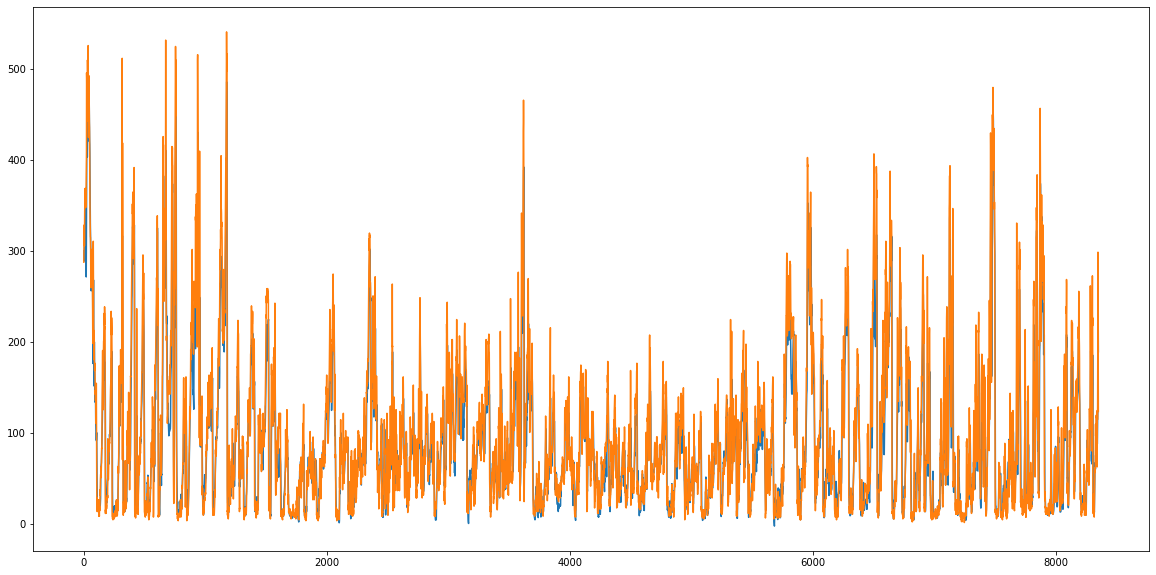

Saving...
Iter:  1 train:  0.030450525929278202 val:  0.02301108154577346
Iter:  2 train:  0.025658088759507213 val:  0.023145529861877286
Iter:  3 train:  0.025251755930708168 val:  0.024481540598607
Saving...
Iter:  4 train:  0.025090197847328168 val:  0.022046691747076984
Iter:  5 train:  0.02476623045013938 val:  0.02224881112176402
Iter:  6 train:  0.02473444950449532 val:  0.022951377866048
Saving...
Iter:  7 train:  0.02459117320357337 val:  0.021918085134102414
Saving...
Iter:  8 train:  0.024388053423957584 val:  0.021432399477353176
Iter:  9 train:  0.02449794800994653 val:  0.021696911984612984
Iter:  10 train:  0.024448241489380032 val:  0.02178829538804504
lr:  0.001
mse:  469.05014 mae:  12.331951


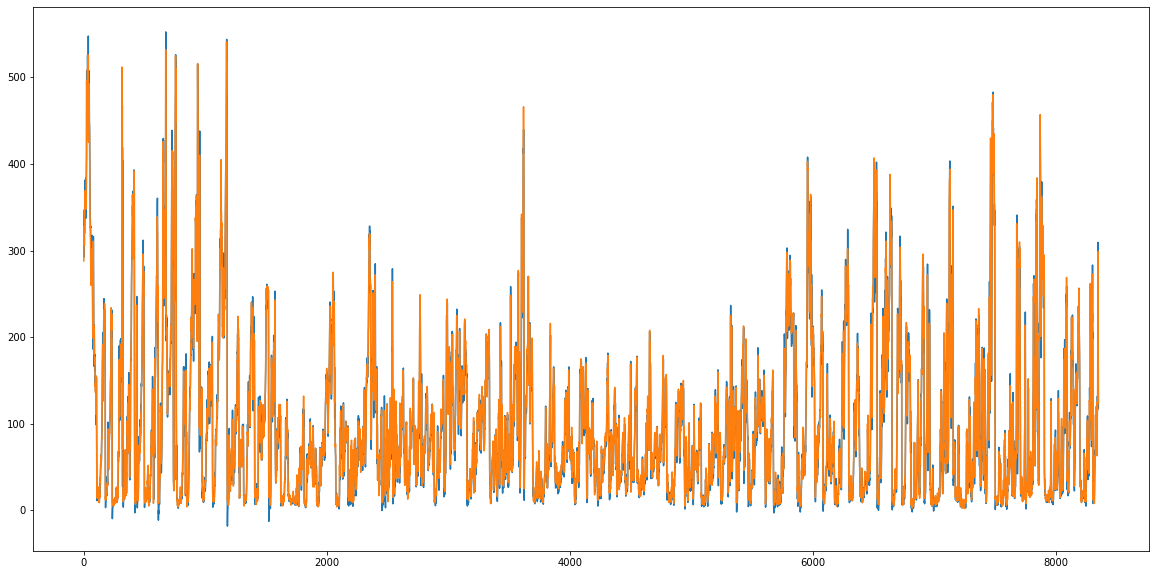

Saving...
Iter:  11 train:  0.024190284914459792 val:  0.02135049834953628
Iter:  12 train:  0.024164662137894238 val:  0.02238835396093016
Iter:  13 train:  0.024096716028212187 val:  0.02156589057656399
Saving...
Iter:  14 train:  0.023989467176967417 val:  0.02133426609518626
Iter:  15 train:  0.02373290607021157 val:  0.021413520606238315
Iter:  16 train:  0.023702890839435775 val:  0.02397428538545393
Iter:  17 train:  0.023733760848846486 val:  0.021366869262936548
Saving...
Iter:  18 train:  0.02411414808491785 val:  0.02128878221402777
Iter:  19 train:  0.023681442336533645 val:  0.021421990558022536
Iter:  20 train:  0.02327919396395789 val:  0.02138525514117729
lr:  0.0008
mse:  451.85764 mae:  12.357019


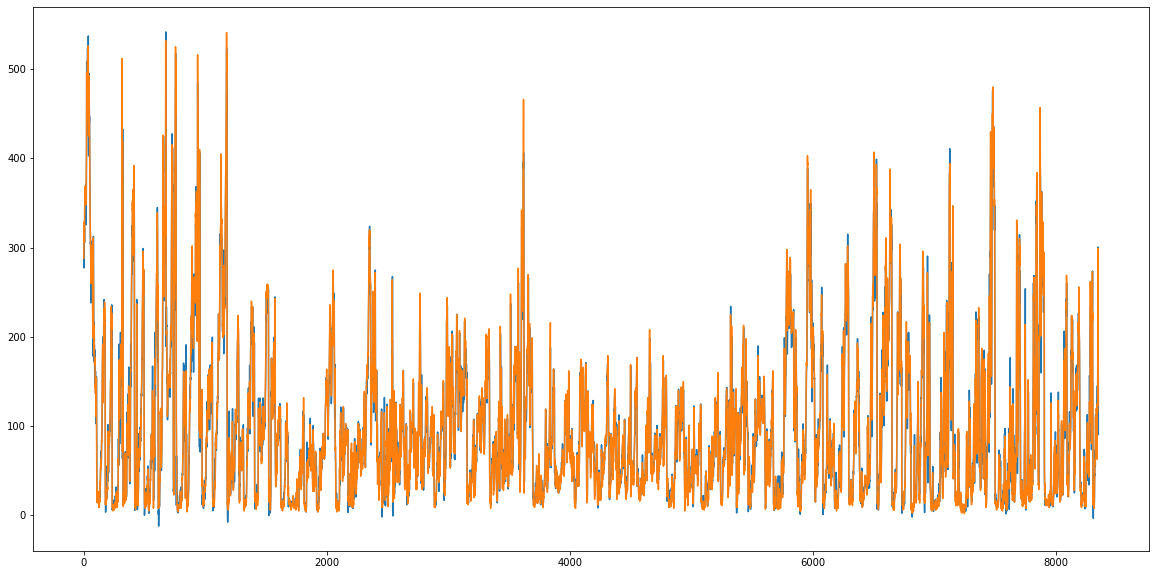

Iter:  21 train:  0.02309304092734663 val:  0.02180089807351902
Iter:  22 train:  0.023008906809487032 val:  0.02203641435480388
Iter:  23 train:  0.02302776511635627 val:  0.021289679864295467
Saving...
Iter:  24 train:  0.022939789711679384 val:  0.021241408386950468
Iter:  25 train:  0.02296780586347479 val:  0.021885408517160383
Saving...
Iter:  26 train:  0.022738501241208058 val:  0.02114440446803665
Iter:  27 train:  0.022595861265196606 val:  0.021604667676405634
Saving...
Iter:  28 train:  0.022599047683113896 val:  0.021076489101504444
Iter:  29 train:  0.022797493672391297 val:  0.021548008761348898
Iter:  30 train:  0.022638458862764662 val:  0.02154714410637821
lr:  0.0008
mse:  458.7248 mae:  12.313294


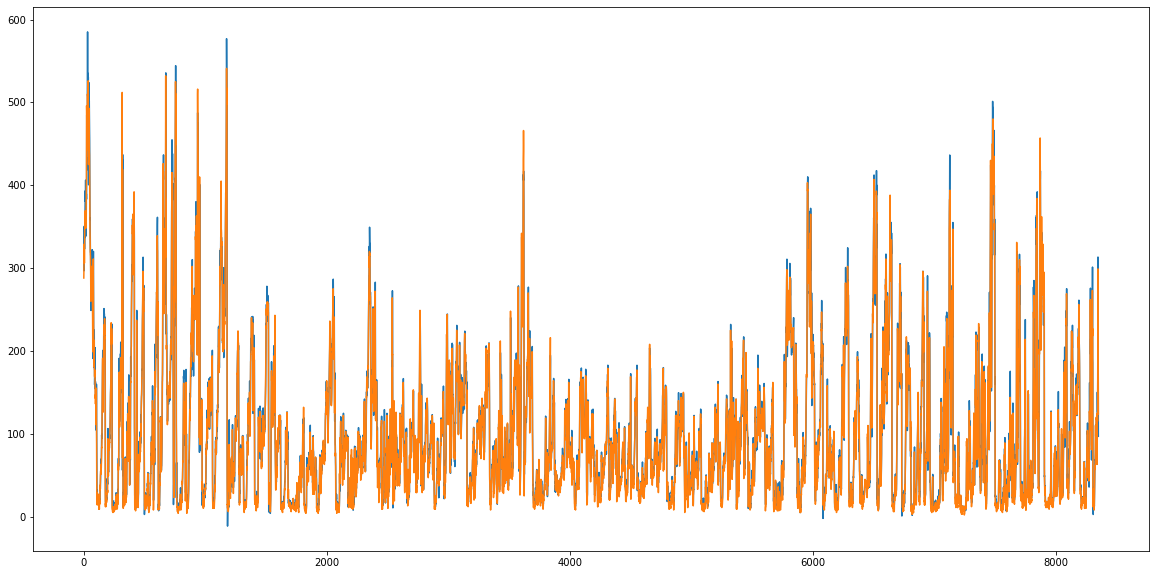

Iter:  31 train:  0.02230036548577081 val:  0.02113579203368289
Iter:  32 train:  0.021882135143737054 val:  0.021816064356072536
Iter:  33 train:  0.023201375246747254 val:  0.021527864994546782


In [ ]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_full_lstm_pm25_512.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("lr: ", opt.param_groups[0]["lr"])
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()


In [ ]:
model.load_state_dict(torch.load("imv_full_lstm_pm25_512.pt"))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [ ]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

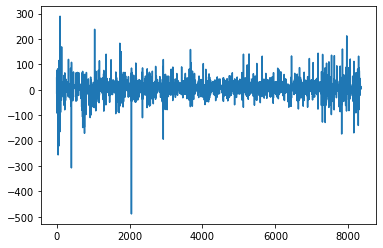

In [ ]:
plt.plot(preds - true)
#plt.plot(true)

In [ ]:
preds.shape, true.shape

((8352,), (8352,))

In [ ]:
evaluate(true, preds)

{'mda': 0.5137109328224164,
 'mnda': 0.2823848238482385,
 'mnp': 0.4244399185336049,
 'mpda': 0.6968461703497104,
 'mpp': 0.5508819538670285,
 'rmse': 26.14932}

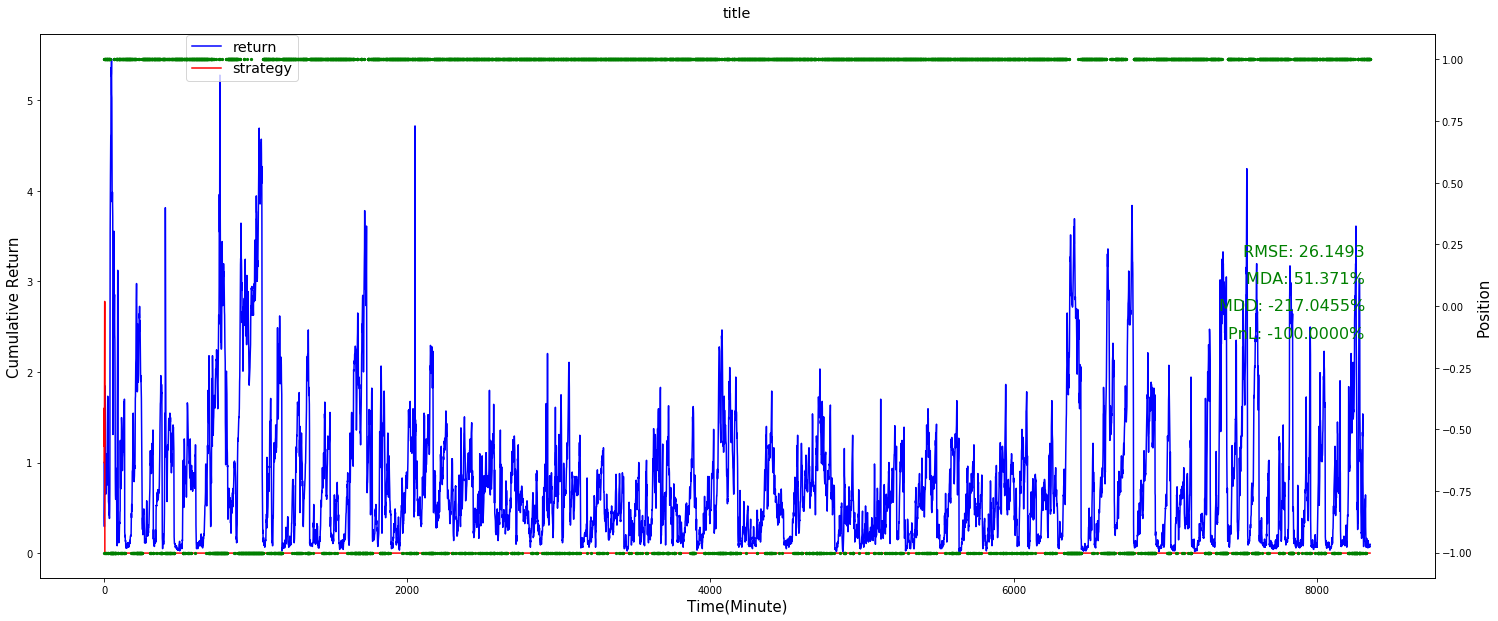

save plots ... 
SR_Annualized:  nan
R2:  0.9230799973011017


In [ ]:
backtesting(true, preds)